<a href="https://colab.research.google.com/github/Lehula1/divergGit/blob/main/scratchpad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install plotly
! pip install numpy
! pip install yfinance
! pip install pandas_ta
! pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from scipy.signal import argrelextrema
import plotly.graph_objects as go

ticker = 'F'
yfObj = yf.Ticker(ticker)
data = yfObj.history(period='6mo', interval='1d')

"""
data1 = yf.download(tickers='SPY', period='30d', interval='1d')

fig = go.Figure(data=[go.Candlestick(x=data1.index,
                                     open=data1['Open'],
                                     high=data1['High'],
                                     low=data1['Low'],
                                     close=data1['Close'])])


fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()
"""

"\ndata1 = yf.download(tickers='SPY', period='30d', interval='1d')\n\nfig = go.Figure(data=[go.Candlestick(x=data1.index,\n                                     open=data1['Open'],\n                                     high=data1['High'],\n                                     low=data1['Low'],\n                                     close=data1['Close'])])\n\n\nfig.update_layout(xaxis_rangeslider_visible=False)\nfig.show()\n"

In [3]:
max_idx = argrelextrema(data['High'].values, np.greater, order=3)[0]
min_idx = argrelextrema(data['Low'].values, np.less, order=3)[0]

print(data.iloc[max_idx])
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)


fig.add_trace(
    go.Scatter(
        mode='markers',
        x=data.index[max_idx],
        y=data.iloc[max_idx,1]+.5,
        marker=dict(
            symbol='cross',
            color='green',
            size=10,
         
        )
    )

)

fig.add_trace(
    go.Scatter(
        mode='markers',
        x=data.index[min_idx],
        y=data.iloc[min_idx,2]-.5,
        marker=dict(
            symbol='cross',
            color='red',
            size=10,
         
        )
    )
)



                                Open       High        Low      Close  \
Date                                                                    
2022-10-06 00:00:00-04:00  11.506733  11.758094  11.348469  11.506733   
2022-11-15 00:00:00-05:00  13.442558  13.715360  13.357895  13.451965   
2022-11-22 00:00:00-05:00  13.216791  13.310860  13.150941  13.235604   
2022-12-01 00:00:00-05:00  13.254419  13.508406  13.169756  13.245011   
2022-12-13 00:00:00-05:00  12.962802  13.094500  12.577117  12.765256   
2023-01-12 00:00:00-05:00  12.483048  12.727628  12.332536  12.633559   
2023-02-02 00:00:00-05:00  13.329674  13.734174  13.197976  13.470778   
2023-02-14 00:00:00-05:00  12.990000  13.190000  12.820000  12.970000   
2023-03-06 00:00:00-05:00  13.080000  13.180000  12.930000  12.980000   
2023-03-22 00:00:00-04:00  11.760000  11.940000  11.470000  11.480000   

                              Volume  Dividends  Stock Splits  
Date                                                       

In [25]:
from collections import deque

close = data['High'].values
dates = data.index






colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Get K consecutive higher peaks
K = 2
high_idx = argrelextrema(data['High'].values, np.greater, order=3)[0]
highs = data.iloc[high_idx]['High']

extrema = []
count = 0
ex_deque = deque(maxlen=K)
for i, idx in enumerate(high_idx):
  if i == 0:
    ex_deque.append(idx)
    continue
  if highs[i] < highs[i-1]:
    ex_deque.clear()
   
  ex_deque.append(idx)

  if len(ex_deque) == K:
    # K-consecutive higher highs found
    extrema.append(ex_deque.copy())
    #extrema count++++++++++++++++++++++++++++++++++++++++++++++++
    print(extrema[count][0])
    print(extrema[count][1])
    count += 1



print(close)

test = data.iloc[extrema[0][0]]['High']

print(close)

tester = extrema[0][0]
print("tester" , tester)
#print(highs)
print(ex_deque)
print(test)
print(extrema.index)
print(extrema[0][1])
print(extrema[1])
print(extrema[2])
print(extrema[-1][1])
print(extrema)
print(high_idx)
print(max_idx)

fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)

#print(data.iloc[high_idx]['High'],high_idx)

4
32
37
43
71
85
[10.73403264 10.78989073 11.51604281 11.69292793 11.75809404 11.45087641
 10.75265146 11.05055978 10.89229578 11.06918093 11.03194156 11.16227622
 11.40432704 11.30192194 11.35777976 11.40432806 11.77671342 12.13048022
 12.15840993 12.30736509 12.39115199 12.57734458 12.70767882 12.72629872
 12.53079647 12.81939615 12.81008596 12.84732435 12.75422741 13.36866496
 13.65726476 13.49900025 13.7153602  13.32967407 13.08509254 13.29204678
 13.20738358 13.31085996 13.22619766 13.27323198 13.13212745 13.07568593
 13.12272052 13.50840619 13.14153551 12.95339611 12.76525562 12.6241514
 12.47364067 12.56770987 12.67118659 13.09450018 12.96280176 12.47364013
 12.0597327  11.44828103 10.98733939 11.09081568 10.85564111 10.72394337
 10.71453766 10.58283981 10.86504855 10.94971194 11.21310604 11.36361804
 11.64582738 11.84337344 12.16321071 12.10676813 12.47364011 12.72762838
 12.05973305 12.08795441 12.08795458 11.62701219 11.68345479 12.14439563
 12.13498839 12.08795446 12.2949070

DatetimeIndex(['2022-10-06 00:00:00-04:00', '2022-11-15 00:00:00-05:00',
               '2022-11-22 00:00:00-05:00', '2022-12-01 00:00:00-05:00',
               '2022-12-13 00:00:00-05:00', '2023-01-12 00:00:00-05:00',
               '2023-02-02 00:00:00-05:00', '2023-02-14 00:00:00-05:00',
               '2023-03-06 00:00:00-05:00', '2023-03-22 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', freq=None)
Date
2022-10-06 00:00:00-04:00    11.758094
2022-11-15 00:00:00-05:00    13.715360
2022-11-22 00:00:00-05:00    13.310860
2022-12-01 00:00:00-05:00    13.508406
2022-12-13 00:00:00-05:00    13.094500
2023-01-12 00:00:00-05:00    12.727628
2023-02-02 00:00:00-05:00    13.734174
2023-02-14 00:00:00-05:00    13.190000
2023-03-06 00:00:00-05:00    13.180000
2023-03-22 00:00:00-04:00    11.940000
Name: High, dtype: float64


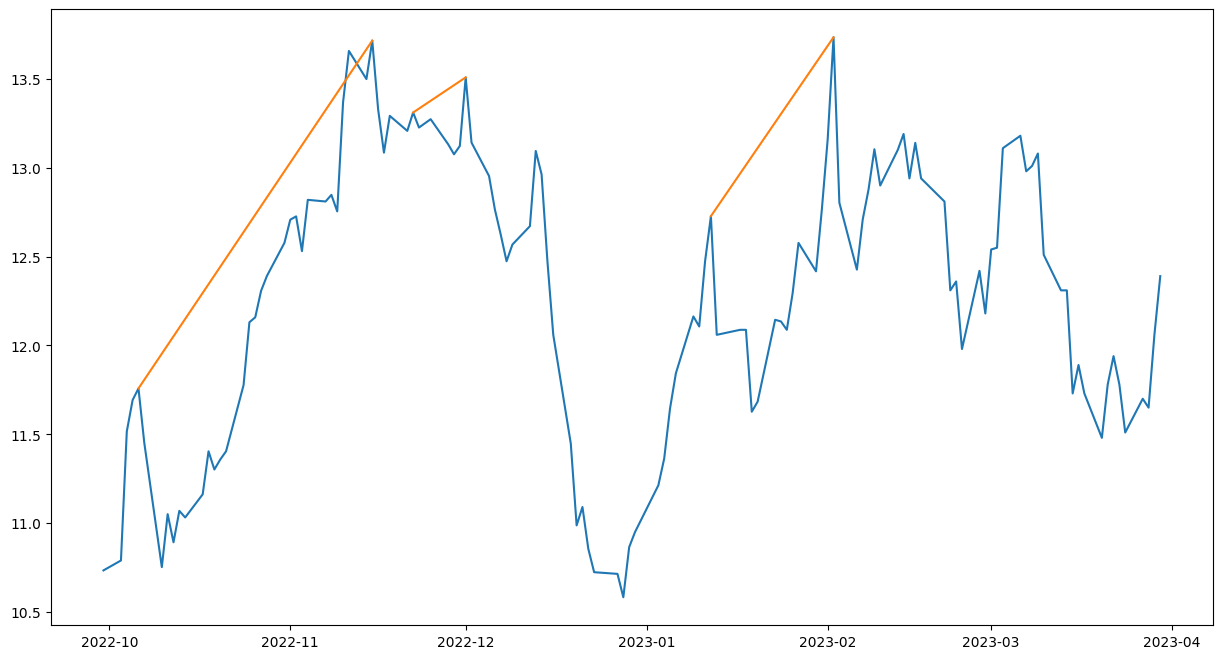

In [37]:


plt.figure(figsize=(15, 8))
plt.plot(data['High'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]

#----------------------------------------------------------


#data1 = () - (data.index[max_idx][1])
#print(highs)
#print(data.index[max_idx][])

#print (data1)
print(data.index[max_idx])
print(data.iloc[max_idx,1])


fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)

fig.add_trace(
    go.Scatter(
        mode='markers',
        x=data.index[max_idx],
        y=data.iloc[max_idx,1]+.5,
        marker=dict(
            symbol='cross',
            color='green',
            size=10,
         
        )
    )
)

fig.add_trace(
    go.Scatter(
        mode='markers',
        x=data.index[min_idx],
        y=data.iloc[min_idx,2]-.5,
        marker=dict(
            symbol='cross',
            color='red',
            size=10,
         
        )
    )
)



fig.add_trace(
    go.Scatter(
        #x=data.index[max_idx],
        x=[data.index[extrema[-1][0]], data.index[extrema[-1][1]]],
        y=[data.iloc[extrema[-1][0],1], data.iloc[extrema[-1][1],1]],
        mode='lines',
        name='trend line',
        line=dict(color='blue')))

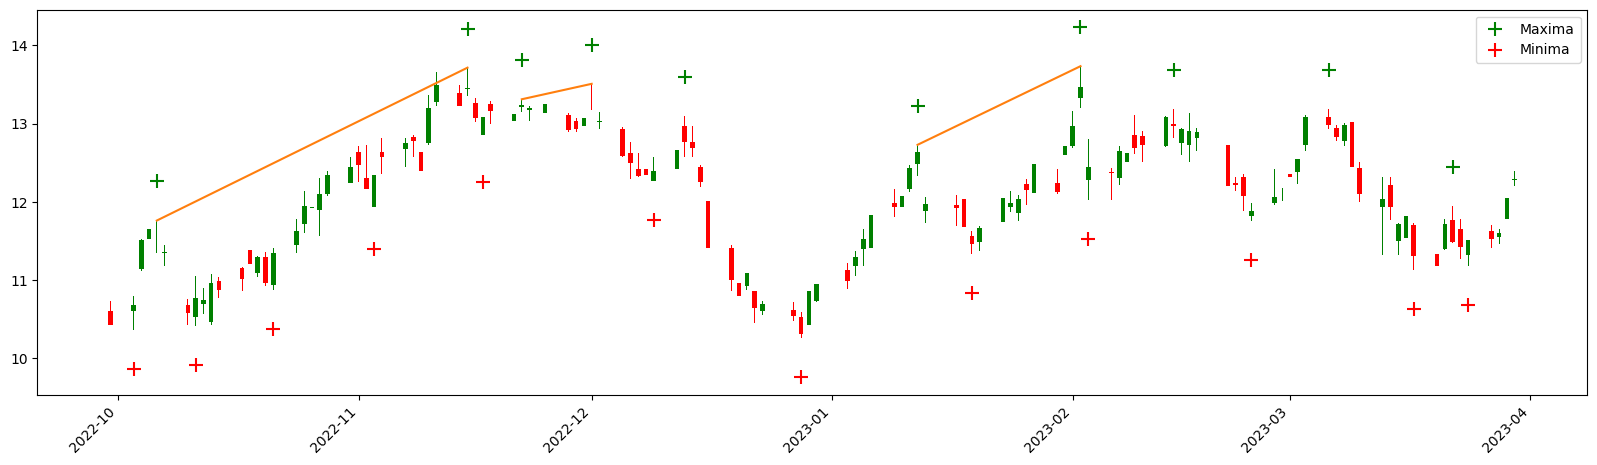

In [11]:
#create figure
plt.figure(figsize=(20,5))

plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['High']+.5,
  label='Maxima', s=100, color='green', marker='+')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Low']-.5,
  label='Minima', s=100, color='red', marker='+')

#define width of candlestick elements
width = .6
width2 = .1

#define up and down prices
up = data[data['Close']>=data['Open']]
down = data[data['Close']<data['Open']]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index,up['Close']-up['Open'],width,bottom=up['Open'],color=col1)
plt.bar(up.index,up['High']-up['Close'],width2,bottom=up['Close'],color=col1)
plt.bar(up.index,up['Low']-up['Open'],width2,bottom=up['Open'],color=col1)

#plot down prices
plt.bar(down.index,down['Close']-down['Open'],width,bottom=down['Open'],color=col2)
plt.bar(down.index,down['High']-down['Open'],width2,bottom=down['Open'],color=col2)
plt.bar(down.index,down['Low']-down['Close'],width2,bottom=down['Close'],color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#lines
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]

plt.legend()
#display candlestick chart
plt.show()